<a href="https://colab.research.google.com/github/tskmr/MIP/blob/main/Lec9(2025_6_16)forPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データ

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# データの定義
t = np.array([0.073, 0.098, 0.117, 0.135, 0.175, 0.262, 0.27, 0.35, 0.386, 0.456])

# 累積分布関数$F_T(t)$のノンパラメトリック推定

累積分布関数$F_T(t)$のノンパラメトリック推定値を，$\hat p = \frac{i-0.5}{n}$で求める．

In [3]:
# 累積確率pの計算
n = len(t)
i = np.arange(1, n + 1)
p = (i - 0.5) / n

# 確率プロットによる分布の特定

位置尺度族から，正規分布・最小極値分布・最大極値分布・ロジスティック分布のクォンタイルを準備

In [4]:

# 逆分布関数の定義
def PhiInv_norm(p):
    return norm.ppf(p)

def PhiInv_sev(p):
    return np.log(-np.log(1 - p))

def PhiInv_lev(p):
    return -np.log(-np.log(p))

def PhiInv_logis(p):
    return np.log(p / (1 - p))


位置尺度族の確率プロット

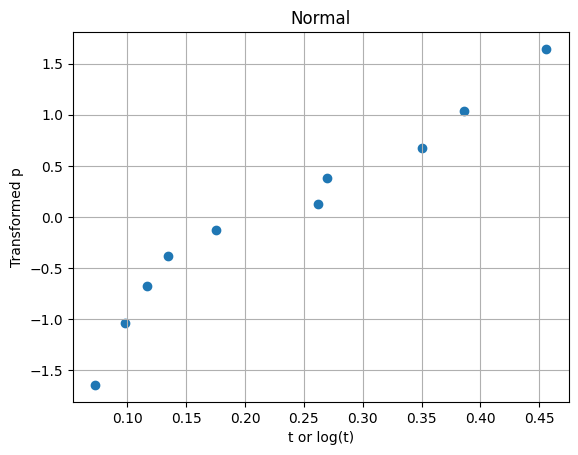

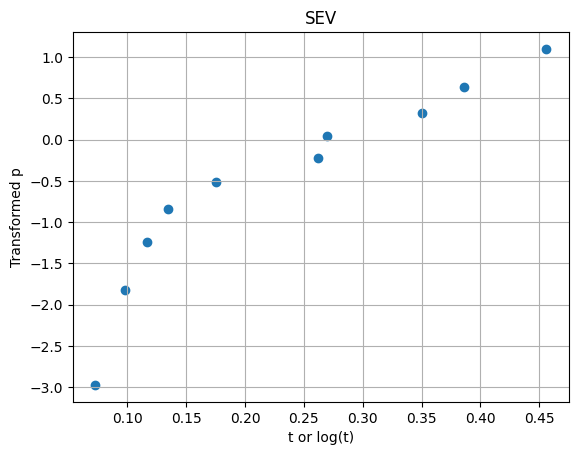

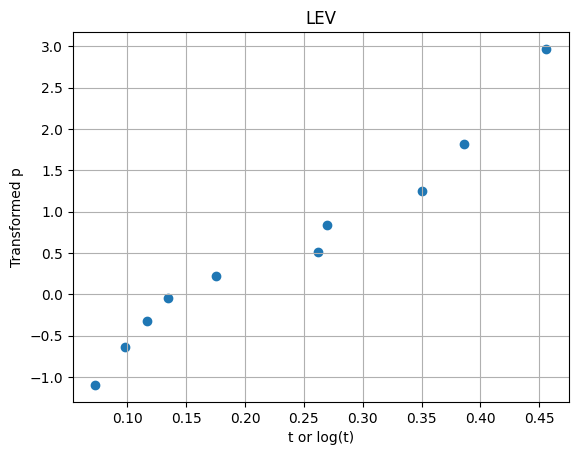

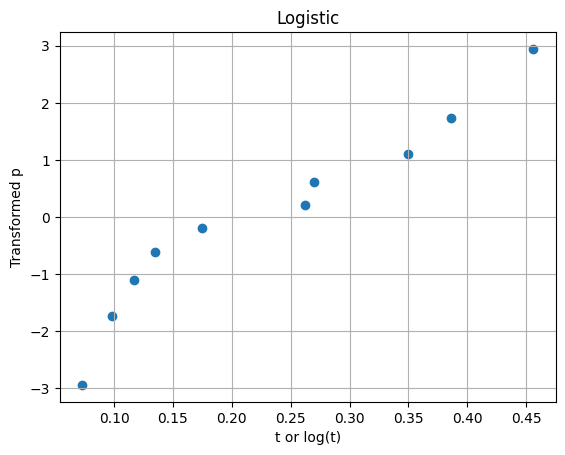

In [5]:
# 各分布でプロットする関数
def plot_dist(x, y, title):
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel('t or log(t)')
    plt.ylabel('Transformed p')
    plt.grid(True)
    plt.show()

# 原点スケール
plot_dist(t, PhiInv_norm(p), "Normal")
plot_dist(t, PhiInv_sev(p), "SEV")
plot_dist(t, PhiInv_lev(p), "LEV")
plot_dist(t, PhiInv_logis(p), "Logistic")


対数位置尺度族の確率プロット（対数正規分布・ワイブル分布・フレシェ分布・対数ロジスティック分布）

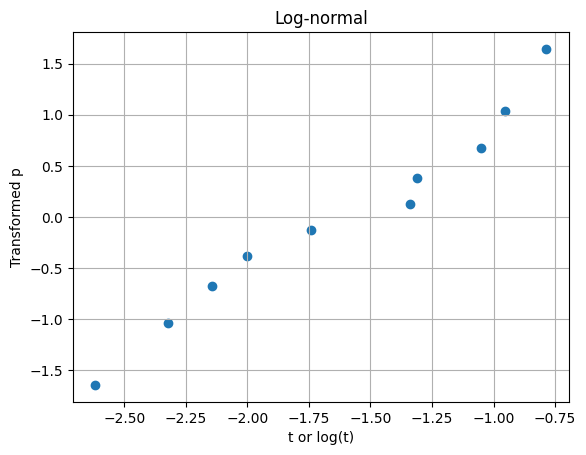

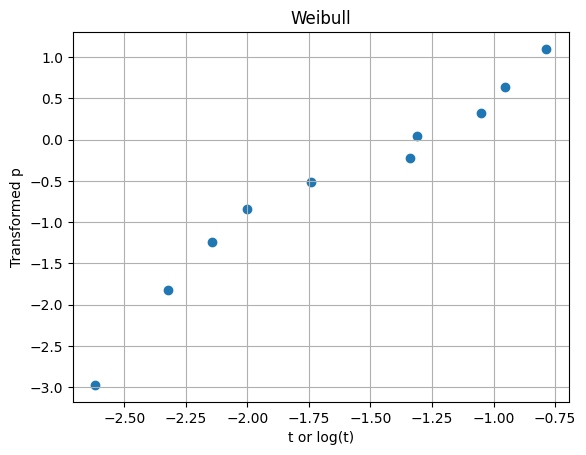

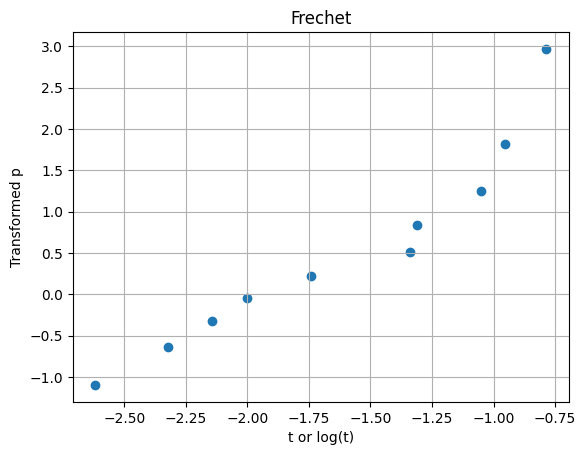

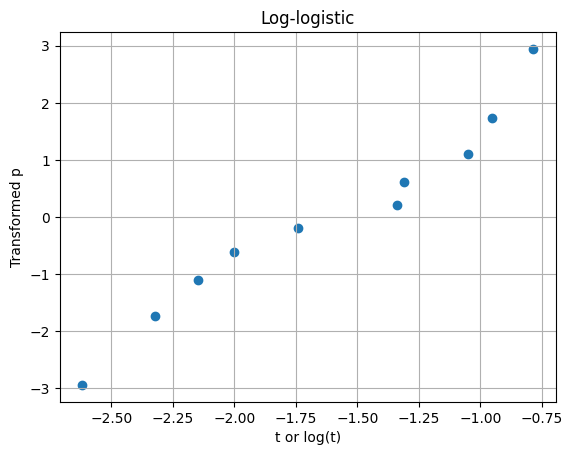

In [6]:
# 対数スケール（tをlog変換）
log_t = np.log(t)
plot_dist(log_t, PhiInv_norm(p), "Log-normal")
plot_dist(log_t, PhiInv_sev(p), "Weibull")
plot_dist(log_t, PhiInv_lev(p), "Frechet")
plot_dist(log_t, PhiInv_logis(p), "Log-logistic")


対数正規分布か，ワイブル分布か，LEVもあり．McCoolの提案するワイブル分布は，ある程度妥当であると言える．

# 最尤推定

対数尤度関数の定義

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# データ
x = np.array([0.073, 0.098, 0.117, 0.135, 0.175, 0.262, 0.27, 0.35, 0.386, 0.456])
n = len(x)
p = (np.arange(1, n + 1) - 0.5) / n

# 標準SEV分布
psev = lambda z: 1 - np.exp(-np.exp(z))
dsev = lambda z: np.exp(z - np.exp(z))

# ワイブル分布の密度と累積分布関数
def ft(x, mu, sigma):
    z = (np.log(x) - mu) / sigma
    return dsev(z) / (x * sigma)

def Ft(x, mu, sigma):
    z = (np.log(x) - mu) / sigma
    return psev(z)

# 対数尤度関数
def neg_log_likelihood(params):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    return -np.sum(np.log(ft(x, mu, sigma)))

対数尤度関数にデータを入れる

対数尤度関数の最大化により，最尤推定値を求める

In [8]:
# 最尤推定
res = minimize(neg_log_likelihood, x0=[-1.0, 1.0], method='L-BFGS-B', jac=None, hess=True)
res

<ipython-input-8-1671283171>:2: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(neg_log_likelihood, x0=[-1.0, 1.0], method='L-BFGS-B', jac=None, hess=True)


  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -7.2821498903827
        x: [-1.335e+00  5.094e-01]
      nit: 6
      jac: [-6.217e-07  8.882e-08]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [9]:
# 最尤推定値を変数に保存
mu_hat, sigma_hat = res.x

得られた最尤推定値が，データをうまく表せているのかを確認するために，ノンパラメトリック推定の結果と重ねてみる．

<ipython-input-7-2518010095>:21: RuntimeWarning: divide by zero encountered in log
  z = (np.log(x) - mu) / sigma


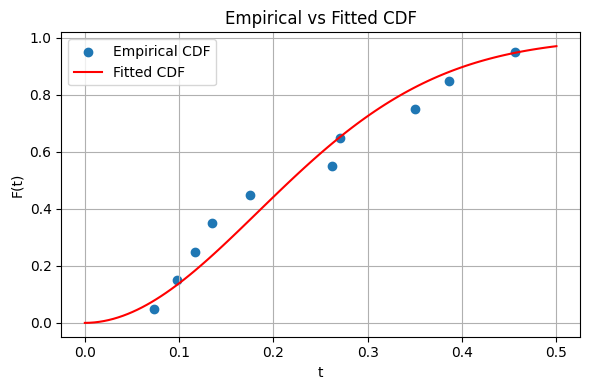

In [10]:
# パラメータ mu, sigma は MLE 結果を使用（ここでは mu_hat, sigma_hat）
tt = np.linspace(0, 0.5, 100)
yy = Ft(tt, mu_hat, sigma_hat)

# データフレームの作成（d 相当）
df_empirical = pd.DataFrame({'t': x, 'p': p})
df_theoretical = pd.DataFrame({'tt': tt, 'yy': yy})

# プロット
plt.figure(figsize=(6, 4))
plt.scatter(df_empirical['t'], df_empirical['p'], label='Empirical CDF')
plt.plot(df_theoretical['tt'], df_theoretical['yy'], color='red', label='Fitted CDF')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.title('Empirical vs Fitted CDF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

同じく，データをうまく表せているのかを確認するために，確率プロットに重ねる．

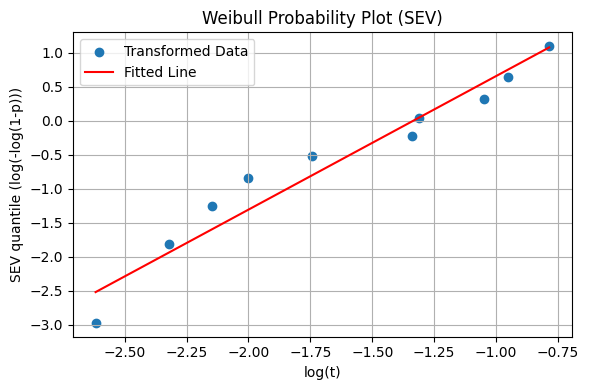

In [11]:
# 傾きと切片の計算
slope = 1 / sigma_hat
intercept = -mu_hat / sigma_hat

# プロット用データ
x_log = np.log(x)
y_sev = PhiInv_sev(p)

# プロット
plt.figure(figsize=(6, 4))
plt.scatter(x_log, y_sev, label='Transformed Data')
x_line = np.linspace(min(x_log), max(x_log), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', label='Fitted Line')

plt.xlabel('log(t)')
plt.ylabel('SEV quantile (log(-log(1-p)))')
plt.title('Weibull Probability Plot (SEV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


また，同じくデータにうまく合っているのかを確認するために，データのヒストグラムと推定したワイブル分布のパラメータによる密度関数を重ねてみる．

<ipython-input-7-2518010095>:17: RuntimeWarning: divide by zero encountered in log
  z = (np.log(x) - mu) / sigma
<ipython-input-7-2518010095>:18: RuntimeWarning: invalid value encountered in divide
  return dsev(z) / (x * sigma)


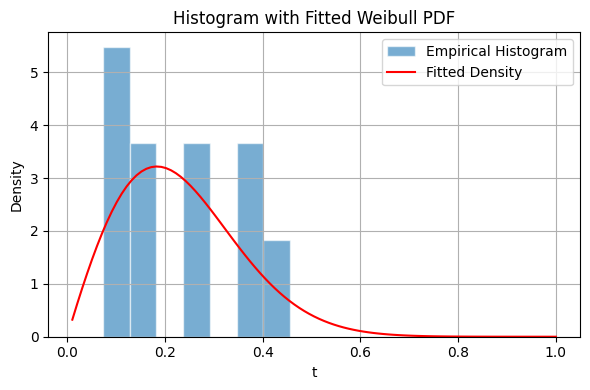

In [12]:
# 横軸の範囲と密度関数の値
tt = np.linspace(0, 1, 100)
yy = ft(tt, mu_hat, sigma_hat)

# プロット
plt.figure(figsize=(6, 4))
plt.hist(x, bins=7, density=True, edgecolor='white', alpha=0.6, label='Empirical Histogram')
plt.plot(tt, yy, color='red', label='Fitted Density')
plt.xlabel('t')
plt.ylabel('Density')
plt.title('Histogram with Fitted Weibull PDF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 最尤推定による区間推定

In [13]:
# 数値ヘッセ行列の逆行列から分散推定
from scipy.optimize import approx_fprime
from scipy.linalg import inv

def hessian(func, params, epsilon=1e-5):
    n = len(params)
    hess = np.zeros((n, n))
    f0 = func(params)
    for i in range(n):
        x1 = np.array(params, copy=True)
        x1[i] += epsilon
        f1 = func(x1)
        for j in range(i, n):
            x2 = np.array(params, copy=True)
            x2[i] += epsilon
            x2[j] += epsilon
            f2 = func(x2)
            x3 = np.array(params, copy=True)
            x3[j] += epsilon
            f3 = func(x3)
            hess[i, j] = hess[j, i] = (f2 - f1 - f3 + f0) / (epsilon ** 2)
    return hess

hess = hessian(neg_log_likelihood, res.x)
cov = inv(hess)
se_mu, se_sigma = np.sqrt(np.diag(cov))

In [14]:
# 95%信頼区間
z_975 = norm.ppf(0.975)
ci_mu = [mu_hat - z_975 * se_mu, mu_hat + z_975 * se_mu]
ci_sigma = [sigma_hat - z_975 * se_sigma, sigma_hat + z_975 * se_sigma]

# 累積分布関数の区間推定

まず，ヤコビ行列を求めるが，楽するために数値微分を用いることを考える．
次に，累積分布関数の漸近分散を求める．最後に累積分布関数の区間推定を行う．

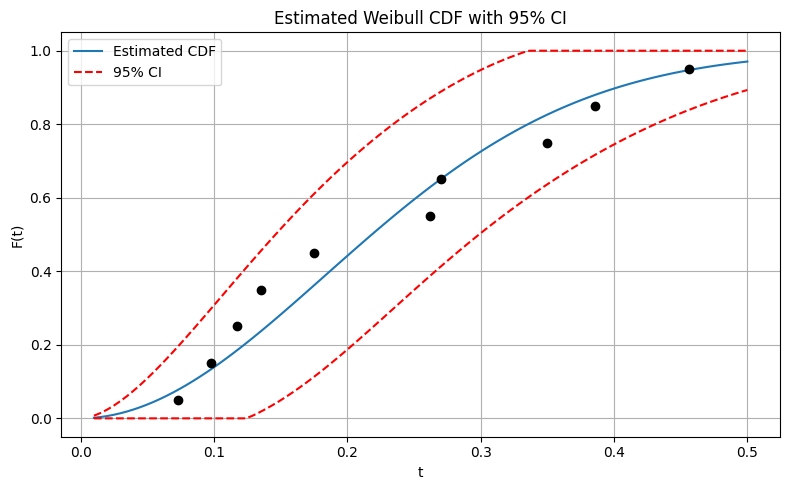

MLE mu: -1.334806625962932 95% CI: [np.float64(-1.6684040848192199), np.float64(-1.0012091671066443)]
MLE sigma: 0.5094071084347442 95% CI: [np.float64(0.25715125164968544), np.float64(0.761662965219803)]


In [16]:
# CDFとその信頼区間
tt = np.linspace(0.01, 0.5, 100)
hat_F = Ft(tt, mu_hat, sigma_hat)

def jacobian(t, mu, sigma, h=1e-5):
    dmu = (Ft(t, mu + h, sigma) - Ft(t, mu - h, sigma)) / (2 * h)
    dsigma = (Ft(t, mu, sigma + h) - Ft(t, mu, sigma - h)) / (2 * h)
    return np.vstack([dmu, dsigma]).T

J = jacobian(tt, mu_hat, sigma_hat)
var_F = np.array([J[i] @ cov @ J[i] for i in range(len(tt))])
se_F = np.sqrt(var_F)
upper = np.minimum(hat_F + z_975 * se_F, 1)
lower = np.maximum(hat_F - z_975 * se_F, 0)

# プロット
plt.figure(figsize=(8, 5))
plt.plot(tt, hat_F, label='Estimated CDF')
plt.plot(tt, upper, 'r--', label='95% CI')
plt.plot(tt, lower, 'r--')
plt.scatter(x, p, color='black', zorder=5)
plt.xlabel('t')
plt.ylabel('F(t)')
plt.title('Estimated Weibull CDF with 95% CI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 信頼区間の表示
print("MLE mu:", mu_hat, "95% CI:", ci_mu)
print("MLE sigma:", sigma_hat, "95% CI:", ci_sigma)
